In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import emukit
import GPy
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
                                                      NegativeLowerConfidenceBound, \
                                                      MaxValueEntropySearch, \
                                                      ProbabilityOfImprovement
from emukit.core.acquisition import IntegratedHyperParameterAcquisition



In [31]:
import pandas as pd
import numpy as np
import os


# Fe  Co  others  Ni Ti  Co_plus

source_name = 'S1'

# folder_path = r'C:\Users\13282\Desktop\papercode\data\Alloy\matminner_processed' 
# folder_path = r'C:\Users\13282\Desktop\papercode\data\Alloy\no_comp' 
folder_path = r'C:\Users\13282\Desktop\papercode\data\Alloy\original_processed' 


file_path = os.path.join(folder_path, 'S1_scaled.xlsx')

df = pd.read_excel(file_path)

#去除存在nan的点
# nan_indices = np.isnan(Y)
# X = X[~nan_indices.flatten()]
# Y = Y[~nan_indices.flatten()]
print(df.shape)

X_all = df.iloc[:, :-1].values  
Y_all = -df.iloc[:, -1].values   

print(X_all.shape,Y_all.shape)

(747, 10)
(747, 9) (747,)


# 预处理

In [32]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# min_max_scaler = MinMaxScaler()

# x_all_normalized = min_max_scaler.fit_transform(X_all)

x_all_normalized = X_all

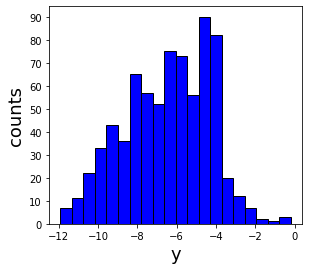

In [33]:
import seaborn as sns
# 创建一个2x1的子图
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 绘制原始y的分布直方图
axes[0].hist(Y_all, bins=20, color='blue', edgecolor='black')

axes[0].set_xlabel('y', fontsize=18)  # 设置x轴标签的字体大小为16
axes[0].set_ylabel('counts', fontsize=18)   # 设置y轴标签的字体大小为16
axes[0].yaxis.set_major_locator(plt.MaxNLocator(integer=True))
# 隐藏后两个子图
for ax in axes[1:]:
    ax.axis('off')  # 关闭坐标轴
    ax.set_visible(False)  # 设置子图为不可见

In [34]:
X = x_all_normalized
Y = Y_all.reshape(-1, 1)

# 训练模型

In [35]:
import time

# 记录开始时间
start_time = time.time()
# 初始化模型




input_dim = len(X[0])

ker = GPy.kern.Matern52(input_dim = input_dim, ARD = True)#

model_var = 0.1
ker.lengthscale.constrain_bounded(0.001, 5) #lengthscale决定着点与点之间的相互作用程度
ker.variance.constrain_bounded(1e-2, 1e4) #方差


# model_var = 0.1
# ker.lengthscale.constrain_bounded(0.001, 20) #lengthscale决定着点与点之间的相互作用程度
# ker.variance.constrain_bounded(1e-2, 1e4) #方差


model_gpy = GPRegression(X,Y, ker)

model_gpy.Gaussian_noise.variance = model_var**2
model_gpy.Gaussian_noise.variance.fix()

model_gpy.randomize()
model_gpy.optimize_restarts(num_restarts=20,verbose =False, messages=False)

base_model_1 = GPyModelWrapper(model_gpy)


# 记录结束时间
end_time = time.time()
execution_time = end_time - start_time
# 计算代码的运行时间
minutes = execution_time // 60
seconds = execution_time % 60
print(f"代码执行时间: {minutes} 分钟 {seconds} 秒")


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


代码执行时间: 4.0 分钟 51.79467797279358 秒


In [36]:
print(base_model_1.model.kern.lengthscale)
print(base_model_1.model.kern.variance)

  index  |  GP_regression.Mat52.lengthscale  |  constraints  |  priors
  [0]    |                       0.00481389  |   0.001,5.0   |        
  [1]    |                       4.23456749  |   0.001,5.0   |        
  [2]    |                       0.50983353  |   0.001,5.0   |        
  [3]    |                       4.99729159  |   0.001,5.0   |        
  [4]    |                       0.67300064  |   0.001,5.0   |        
  [5]    |                       0.55269826  |   0.001,5.0   |        
  [6]    |                       0.02650640  |   0.001,5.0   |        
  [7]    |                       0.09466168  |   0.001,5.0   |        
  [8]    |                       5.00000000  |   0.001,5.0   |        
  index  |  GP_regression.Mat52.variance  |  constraints   |  priors
  [0]    |                   60.53974885  |  0.01,10000.0  |        


Train Set Metrics:
MAE: 0.03   RMSE: 0.07   spearman: 0.999   R² score: 0.999


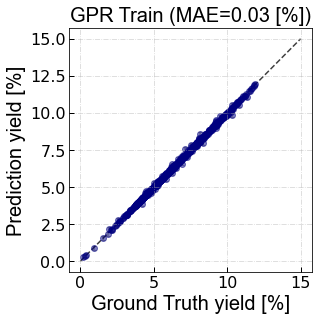

In [37]:
f_obj =  base_model_1.model.predict
y_pred, y_uncer = f_obj(X)
y_pred = -y_pred[:,-1]
y_uncer = np.sqrt(y_uncer[:,-1])
y_truth = -Y[:,-1]

from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from scipy.stats import spearmanr
fig, axes = plt.subplots(1, 3, figsize=(5.5*3, 4.5))
fs = 20
lims1 = (0, 15)
axes[0].scatter(y_truth, y_pred, alpha = 0.5, c = 'navy' , edgecolor = 'navy')
axes[0].errorbar(y_truth, y_pred, yerr = y_uncer, ms = 0, 
                 ls = '', capsize = 2, alpha = 0.6,
                 color = 'gray', zorder = 0)
axes[0].plot(lims1, lims1, 'k--', alpha=0.75, zorder=0)

rmse_value = np.sqrt(mean_squared_error(y_truth, y_pred))
mae_value = mean_absolute_error(y_truth, y_pred)
spearman_value = spearmanr(y_truth, y_pred)[0]
rsquared_value = r2_score(y_truth, y_pred)

print('Train Set Metrics:')
print('MAE:',np.round(mae_value,2), ' ',
      'RMSE:', np.round(rmse_value,2), ' ',
      'spearman:', np.round(spearman_value,3), ' ',
      'R² score:', np.round(rsquared_value,3))

title = 'GPR Train' + " (MAE=%.2f" % mae_value+' [%])'
axes[0].set_xlabel('Ground Truth yield [%]', fontproperties='Arial',fontsize = fs)
axes[0].set_ylabel('Prediction yield [%]',fontproperties='Arial', fontsize = fs)
axes[0].set_title(title, fontsize = fs,fontproperties='Arial')
        
for i in range(len(axes)):
    axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
    axes[i].grid(True, linestyle='-.')
plt.subplots_adjust(wspace = 0.4)

# 隐藏后两个子图
for ax in axes[1:]:
    ax.axis('off')  # 关闭坐标轴
    ax.set_visible(False)  # 设置子图为不可见

plt.show()


# 保存源模型为文件

In [38]:
import pickle
import os


# 定义文件夹路径
# folder_path = 'matminer' 'original'  'no_comp'
folder_path = 'original'

# 如果文件夹不存在，则创建文件夹
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# 保存 base_model_1 到文件
with open(os.path.join(folder_path,  f'{source_name}.pkl'), 'wb') as f:
    pickle.dump(base_model_1, f)

# # 保存 nlcb_1 到文件
# with open(os.path.join(folder_path, 'nlcb_1.pkl'), 'wb') as f:
#     pickle.dump(nlcb_1, f)